# Forecasting each city using MLP

- Forecast cities, get .5C years,   
- Get difference from global  
- Regression on city-diff to get coefficients  
- Regression on coefficients with altitude and CO2 levels to get importance  

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
# fix random seed
np.random.seed(10)

In [28]:
# Get data

colnames    = ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty','City','Country','Latitude','Longitude']
newnames    = ['dt', 'at', 'atu','city','country','lat','long']
datatypes   = {'dt': 'str','at':'float32','atu':'float32','city': 'str','country': 'str','lat':'float32','long':'float32'}
#df = pd.read_csv("../Input/Temperature/GlobalLandTemperaturesByMajorCity.csv")
df = pd.read_csv("../Input/Temperature/GlobalLandTemperaturesByMajorCity.csv",    
                            usecols = colnames, 
                            dtype = datatypes)
df.columns = newnames
df = df.loc[df['country']=='United States']
df = df[pd.notnull(df['at'])]
df['year'] = df['dt'].map(lambda x: int(x.split('-')[0]))
df['month'] = df['dt'].map(lambda x: int(x.split('-')[1]))
df['dt'] = df['dt'].map(lambda x: str(x.rsplit('-',1)[0]))
df = df.loc[df['year']>=1850,:]
df.head(3)

,dt,at,atu,city,country,lat,long,year,month
52948,1850-01,1.381,1.429,Chicago,United States,42.59N,87.27W,1850,1
52949,1850-02,0.914,1.607,Chicago,United States,42.59N,87.27W,1850,2
52950,1850-03,1.666,3.186,Chicago,United States,42.59N,87.27W,1850,3


In [29]:
citiesL=set(df['city'])
print(len(citiesL))
print(citiesL)

3
{'Chicago', 'New York', 'Los Angeles'}


In [154]:
dfAnnual=df.groupby(['city','year']).mean()
dfAnnual=dfAnnual.drop('month',axis=1)
dfAnnual.head(6)

at       atu
city    year                     
Chicago 1850   9.889250  1.737167
        1851  10.168917  1.763917
        1852   9.820583  1.785000
        1853  10.205000  1.744750
        1854  10.960917  1.476750
        1855   9.713417  1.509667

In [155]:
#graph=dfAnnual[dfAnnual['year']>1850]
graph=df[['year','month','city','at']]
graph.head(3)

,year,month,city,at
52948,1850,1,Chicago,1.381
52949,1850,2,Chicago,0.914
52950,1850,3,Chicago,1.666


In [156]:
#graph=major_indian_cities[indian_cities['year']>1900]
graph=graph.groupby(['city','year'])['at'].mean().reset_index()
graph.head()

,city,year,at
0,Chicago,1850,9.889250
1,Chicago,1851,10.168917
2,Chicago,1852,9.820583
3,Chicago,1853,10.205000
4,Chicago,1854,10.960917


In [157]:
graph=graph.pivot('year','city','at').fillna(0)
graph.head()

city,Chicago,Los Angeles,New York
year,,,
1850,9.889250,15.27825,9.095750
1851,10.168917,15.52650,9.263500
1852,9.820583,15.61100,8.982250
1853,10.205000,16.27400,9.675083
1854,10.960917,15.74150,9.561333


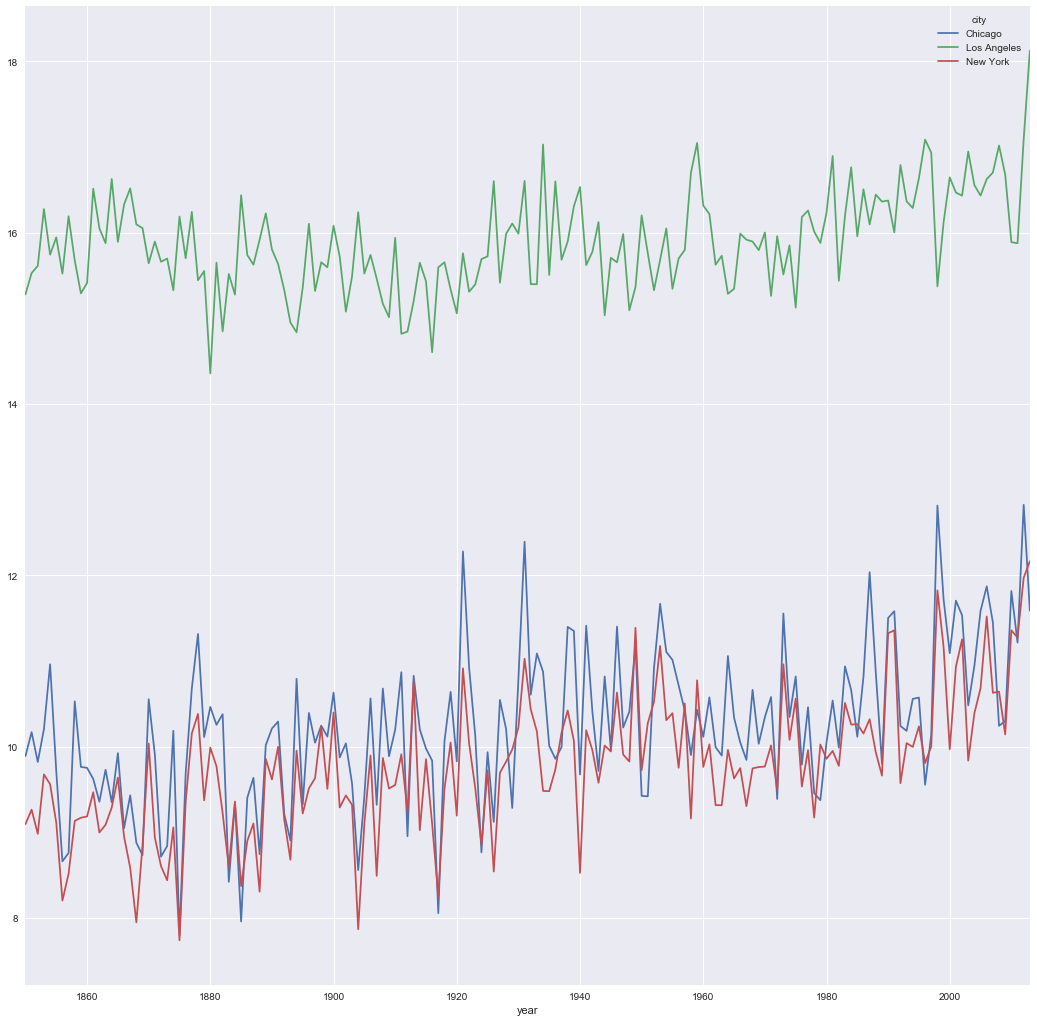

In [158]:
graph.plot()
fig=plt.gcf()
fig.set_size_inches(18,18)

In [159]:
type(graph['Chicago'])
dfAnnual.head()
#dfAnnual.loc[dfAnnual['city']=='Chicago']
dfAnnual['at']['Chicago'][0:3]

year
1850     9.889250
1851    10.168917
1852     9.820583
Name: at, dtype: float64

In [160]:
df0 = pd.read_csv("../Input/Temperature/GlobalTemperatures.csv")
df0 = df0.rename(columns={'LandAverageTemperature':'at'})
df0 = df0[pd.notnull(df0['at'])]
df0['year'] = df0['dt'].map(lambda x: int(x.split('-')[0]))
df0['month'] = df0['dt'].map(lambda x: int(x.split('-')[1]))
df0['dt'] = df0['dt'].map(lambda x: str(x.rsplit('-',1)[0]))
df0=df0.loc[df0['year'].isin(range(1850,2014))]
df0=df0[['year','month','at']]
df0.head()
df0Annual=df0.groupby('year').mean()
print(df0Annual.shape)
df0Annual.head(3)
df0Annual.tail(3)

(164, 2)


,month,at
year,,
2011,6.5,9.516000
2012,6.5,9.507333
2013,6.5,9.606500


In [161]:
dfAnnual['at'].tail(3)
#dfAnnual['at'].shape
#492/3

city      year
New York  2011    11.272250
          2012    11.971500
          2013    12.163889
Name: at, dtype: float64

In [170]:
# Take differences from global temps and do regression
yearsL=range(1850,2014)
diffs=pd.DataFrame(index=yearsL,columns=['atDiff-Chicago','atDiff-Los Angeles','atDiff-New York'])   
for city in citiesL:
    col='atDiff-'+str(city)
    diffs[col] = (dfAnnual['at'][city]-df0Annual['at'])
#    diffs[col] = diffs[col]/np.mean(diffs.loc[1850:1860,col]) # normalized by city mean first decade
    diffs[col] = diffs[col] #LA hotter than global average
    diffs[col] = diffs[col] - np.mean(diffs[col])
diffs.index.name = 'year'
diffs.head(4)

,atDiff-Chicago,atDiff-Los Angeles,atDiff-New York
year,,,
1850,0.302959,0.052911,-0.021880
1851,0.304709,0.023244,-0.132047
1852,0.034792,0.186161,-0.334880
1853,0.477542,0.907494,0.416287


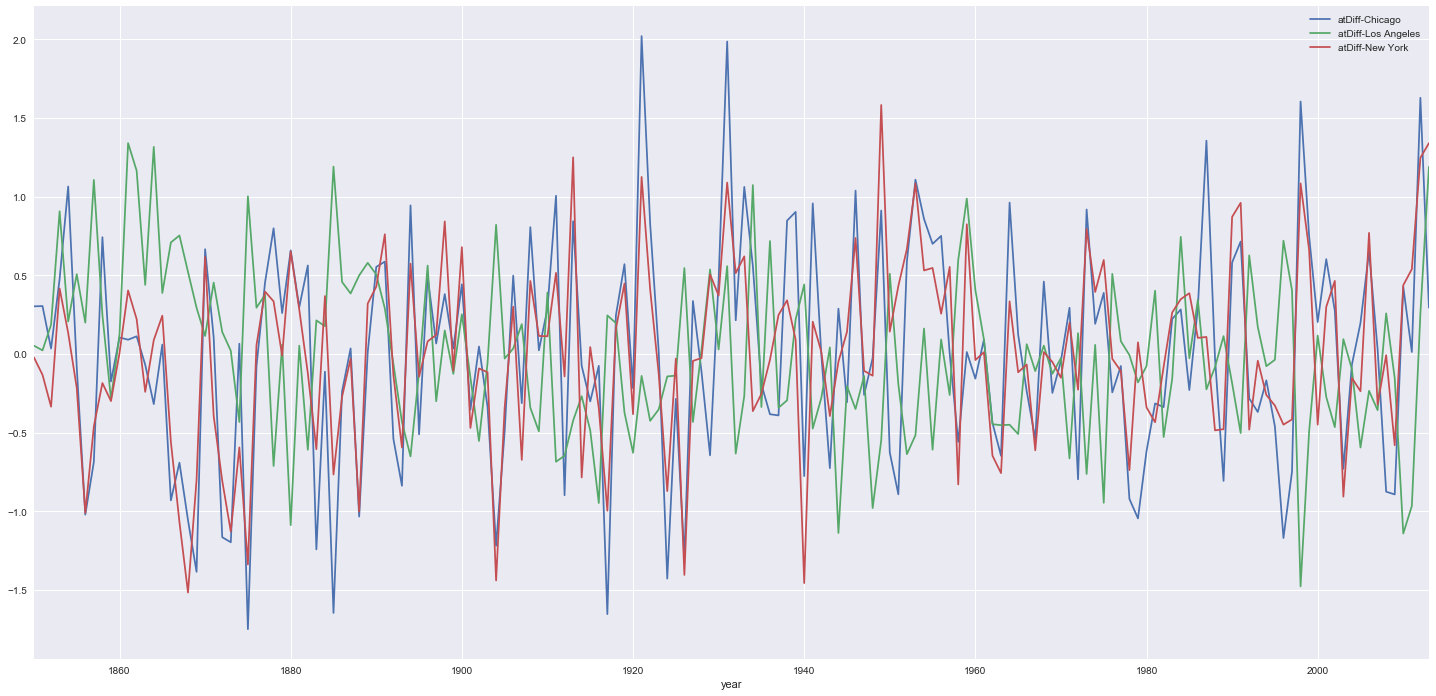

In [171]:
graph=diffs
graph.plot()
fig=plt.gcf()
fig.set_size_inches(25,12)

# Chicago has the most variable annual temps, 
# Chicago and NYC seem more correlated, which means annual variations might 
# be due to weather patterns

In [ ]:
# Let's average diffs over decades

In [300]:
diffs10=diffs
diffs10['decade']=diffs10.index

diffs10['decade']=diffs10['decade'].apply(lambda x: round(x,-1))
diffs10 = diffs10.groupby('decade').mean()
diffs10.head(3)

,atDiff-Chicago,atDiff-Los Angeles,atDiff-New York
decade,,,
1850,0.436959,0.275227,0.012270
1860,-0.112572,0.595312,-0.131319
1870,-0.620495,0.286225,-0.694102


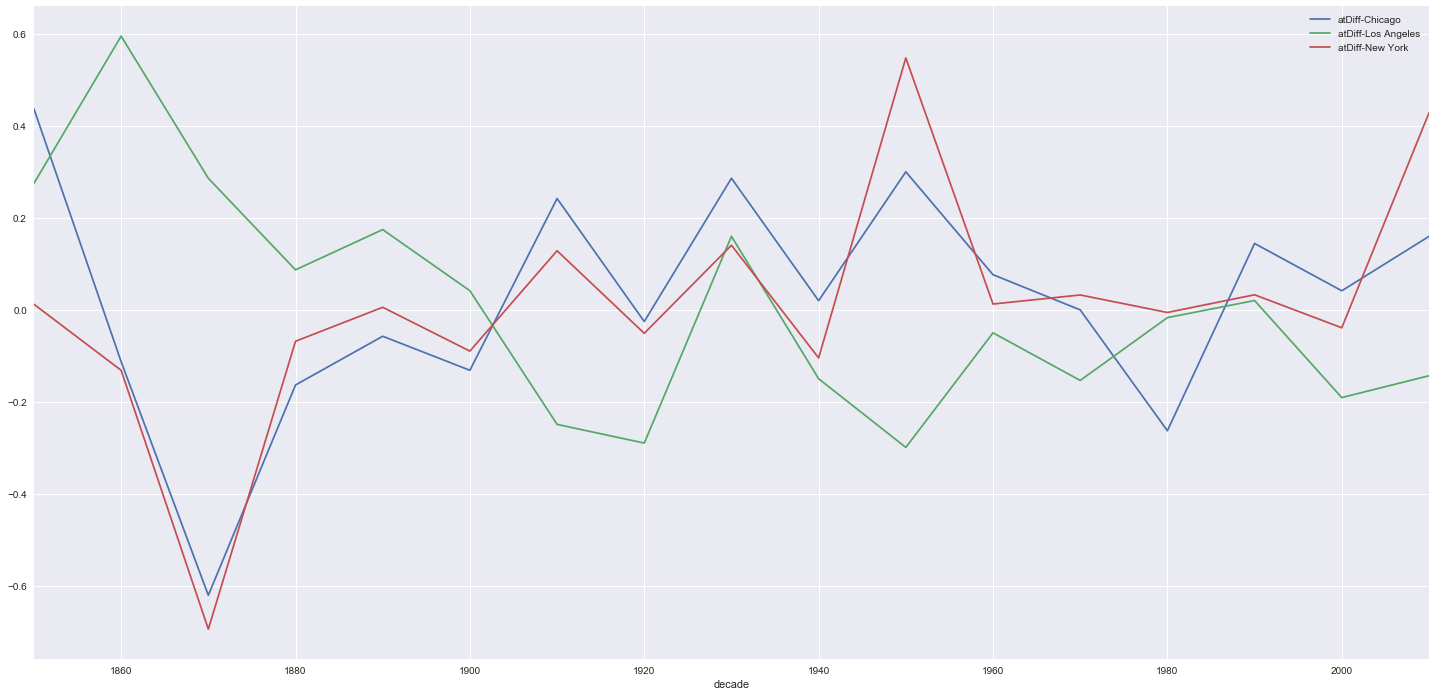

In [301]:
graph=diffs10
graph.plot()
fig=plt.gcf()
fig.set_size_inches(25,12)

In [ ]:
# Even averaging over 10 years, Chicago and NYC are highly correlated, 
# LA is anti-correlated to Chicago and NYC and has a downward curve, meaning that it 
# is heating up at a rate slower than the overall global average.

# Let's try some regression  
moving average would also be good

In [276]:
from   sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

In [277]:
def addpolynomialfeatures(subX, x):
    subX['x**2'] = x**2
    subX['x**3'] = x**3
    subX['sqrt(x)'] = x**.5
#     subX['x5'] = np.sin(x)
#     subX['x6'] = np.cos(x)
    subX['log(x)'] = np.log(x)

*** Regression for atDiff-Chicago
Coefficients: 
 [[  6.62310918e+03  -1.14871049e+00   1.19089198e-04  -3.07230157e+05
   -4.47673612e+04]]
Mean of error: 0.47
*** Regression for atDiff-Los Angeles
Coefficients: 
 [[ -2.06534882e+03   3.60400038e-01  -3.75829612e-05   9.55051080e+04
    1.39163252e+04]]
Mean of error: 0.23
*** Regression for atDiff-New York
Coefficients: 
 [[  4.60693108e+03  -8.00752053e-01   8.31936540e-05  -2.13470935e+05
   -3.11054519e+04]]
Mean of error: 0.31


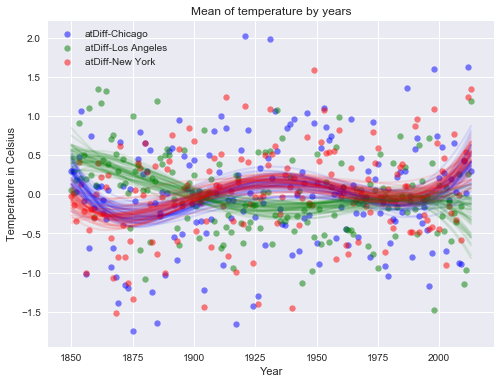

In [279]:
graphData = diffs
plt.figure(figsize=(8,6))
coeffL=['x','x**2','x**3','sqrt(x)','log(x)'] #should match addpolynomialfeatures
coeffs=pd.DataFrame(index=graphData.columns,columns=coeffL)
for col in diffs.columns:
    print('*** Regression for '+str(col))
    ii=diffs.columns.get_loc(col)
    colorL=['blue','green','red']
    graphCol= col
    X         = pd.DataFrame(graphData.index)
    X.head(3)
    addpolynomialfeatures(X, X['year'])
    y         = pd.DataFrame(graphData[graphCol])
    X.index   = X['year']
    Xy        = pd.concat([X,y], axis=1)
    regresor  = linear_model.LinearRegression()
    regresor2 = linear_model.BayesianRidge(compute_score=True)
    regresor2.fit(X, y)
    predict2   = regresor2.predict(X)
    regresor.fit(X,y,5000)
    predict   = regresor.predict(X)
    print('Coefficients: \n', regresor.coef_)
    print("Mean of error: %.2f" % np.mean((predict - y) ** 2))
    for jj in range(len(coeffs.columns)):
        coeffs.ix[col,jj] = regresor.coef_[0][jj]
    plt.scatter(graphData.index, graphData[graphCol], s=40, c=colorL[ii], alpha=0.5, linewidths=0, label=col)
    for i in range(50): # Draw 50 regression curves
        sample = Xy.sample(n=100) #randomly sample n points
        X_test = sample[Xy.columns[:-1]]
        y_test = sample[Xy.columns[-1]]
        regresor.fit(X_test,y_test)
        predict   = regresor.predict(X)
        plt.plot(graphData.index, predict, c=colorL[ii], alpha=0.1, linewidth=2.)
        plt.legend(loc='upper left')
    if ii==0:
        plt.xlabel('Year')
        plt.ylabel('Temperature in Celsius')
        plt.title('Mean of temperature by years')

#plt.show(plotL[0])
    #plotL[ii]=[plt]
    #plt.savefig('AnnualGlobalTemperature_LinReg.png')

In [280]:
coeffs

,x,x**2,x**3,sqrt(x),log(x)
atDiff-Chicago,6623.11,-1.14871,0.000119089,-307230,-44767.4
atDiff-Los Angeles,-2065.35,0.3604,-3.7583e-05,95505.1,13916.3
atDiff-New York,4606.93,-0.800752,8.31937e-05,-213471,-31105.5


# Bayesian Ridge regression (L2 regularization)

*** Regression for atDiff-Chicago
*** Regression for atDiff-Los Angeles
*** Regression for atDiff-New York


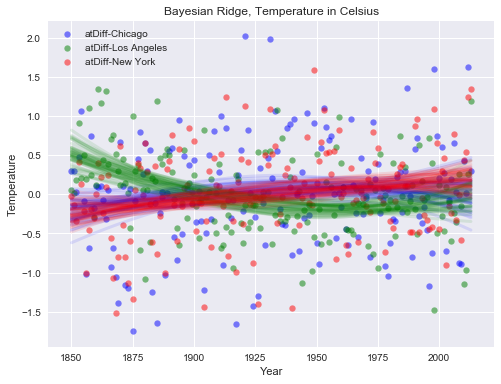

In [288]:
graphData = diffs
plt.figure(figsize=(8,6))
coeffL=['x','x**2','x**3','sqrt(x)','log(x)'] #should match addpolynomialfeatures
coeffs=pd.DataFrame(index=graphData.columns,columns=coeffL)
for col in diffs.columns:
    print('*** Regression for '+str(col))
    ii=diffs.columns.get_loc(col)
    colorL=['blue','green','red']
    graphCol= col
    X         = pd.DataFrame(graphData.index)
    X.head(3)
    addpolynomialfeatures(X, X['year'])
    y         = pd.DataFrame(graphData[graphCol])
    X.index   = X['year']
    Xy        = pd.concat([X,y], axis=1)
    regresor2 = linear_model.BayesianRidge(compute_score=True)
    regresor2.fit(X, y)
    predict2   = regresor2.predict(X)
#     print('Coefficients: \n', regresor2.coef_)
#     print("Mean of error: %.2f" % np.mean((predict - y) ** 2))
#     for jj in range(len(coeffs.columns)):
#         coeffs.ix[col,jj] = regresor.coef_[0][jj]
    plt.scatter(graphData.index, graphData[graphCol], s=40, c=colorL[ii], alpha=0.5, linewidths=0, label=col)
    #plt.figure(figsize=(8,6))
    #plt.scatter(graphData.index, graphData[graphCol], s=40, c='lightblue', alpha=0.5, linewidths=0, label='Expected Output')
    for i in range(50):
        sample = Xy.sample(n=80)
        X_test = sample[Xy.columns[:-1]]
        y_test = sample[Xy.columns[-1]]
        regresor2.fit(X_test,y_test)
        predict2   = regresor2.predict(X)
        plt.plot(graphData.index, predict2, c=colorL[ii], alpha=0.1, linewidth=3.)
        plt.legend(loc='upper left')
        if ii==0:
            plt.xlabel('Year')
            plt.ylabel('Temperature')
            plt.title('Bayesian Ridge, Temperature in Celsius')
            #plt.savefig('Arintemperaturev1r3.png')

# Add Altitudes

In [32]:
altitudes=pd.read_csv("../Input/Geographical/CityAltitudes.csv") #in meters

In [52]:
temp1 = altitudes.loc[altitudes['City'].isin(citiesL),['City','Altitude']]
temp1.loc[4] = ['New York',int(10)]
temp1 = temp1.groupby('City').mean().reindex() #take ave of two alts for LA
temp1.rename(columns={'City':'city'},inplace=True)
temp1['city']=temp1.index
temp1.head(4)

,Altitude,city
City,,
Chicago,181,Chicago
Los Angeles,126,Los Angeles
New York,10,New York


In [53]:
temp1.columns

Index(['Altitude', 'city'], dtype='object')

In [55]:
#Merge with rest of df
temp2 = pd.merge(df, temp1, on='city')
temp2.head(3)

,dt,at,atu,city,country,lat,long,year,month,Altitude
0,1850-01,1.381,1.429,Chicago,United States,42.59N,87.27W,1850,1,181
1,1850-02,0.914,1.607,Chicago,United States,42.59N,87.27W,1850,2,181
2,1850-03,1.666,3.186,Chicago,United States,42.59N,87.27W,1850,3,181


# Add CO2 levels

In [60]:
co2=pd.read_csv("../Input/CO2/archive.csv") #units?
co2.head(5)
#set(co2['Year']) #1958 - 2017

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [ ]:
globTemp=df0Annual.loc[df0Annual['year'].isin(range(1958,2014))]